# 

# Titanic Data Exploration
The goal of this project is to demonstrate my knowledge with classical machine learning models and improve my data cleaning, processing and analysis.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data loading and analysis
We start by loading `data/train.csv` which contains our titanic passenger's features.

In [107]:
raw_data = pd.read_csv('../data/train.csv')
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Our dataset consists of several features. According to Kaggle's evaluations, `Survived` is the primary column of concern and the target label we aim to predict. This label contains two values: **0** (the passenger did not survive) and **1** (the passenger survived).

While there are many columns in the dataset, a select few are likely to be fruitful for training our model. Based on historical context, the following features are key determinants of a passenger's survivability:

- `Pclass`: Socioeconomic status, which often dictated access to lifeboats.
- `Sex`: Gender, as women were prioritized during evacuation.
- `Age`: Age, which relates to both fitness and the "women and children first" policy.
- `SibSp`: The number of siblings or spouses on board; having family can influence evacuation behavior.
- `Parch`: The number of parents or children on board, which may similarly impact the ability to board a lifeboat.
- `Fare`: Ticket price; a sign of wealth that could influence a passenger's chances of survival.
- `Cabin`: Although convoluted, we can extract the deck level from it that can significant influence survival rate
Let's extract these specific columns along with our target, `Survived`.

In [108]:
pass_data = raw_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']]
pass_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,0,3,male,22.0,1,0,7.2500,NaN
1,1,1,female,38.0,1,0,71.2833,C85
2,1,3,female,26.0,0,0,7.9250,NaN
3,1,1,female,35.0,1,0,53.1000,C123
4,0,3,male,35.0,0,0,8.0500,NaN


Let's extract `Raw Deck` (for the purposes of getting dummies in the future) and `Deck` from `Cabin`. We will only extract the first character from Cabin, and we will input the value `U` for missing decks.

In [ ]:
pass_data['Deck'] = pass_data['Cabin'].str.get(0)

pass_data['Deck'] = pass_data['Deck'].fillna('U')
pass_data['Deck'] = pass_data['Deck'].replace('T', 'U')

del pass_data['Cabin']
print(pass_data['Deck'].value_counts())

Deck
U    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: count, dtype: int64


Next, we check the data for any signs of NA and anomalies.

In [110]:
num_rows = len(pass_data)
na_rate = len(pass_data[pass_data['Pclass'].isna()]) / num_rows
print(f"Pclass's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['Sex'].isna()]) / num_rows
print(f"Sex's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['Age'].isna()]) / num_rows
print(f"Age's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['SibSp'].isna()]) / num_rows
print(f"SibSp's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['Parch'].isna()]) / num_rows
print(f"Parch's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['Fare'].isna()]) / num_rows
print(f"Fare's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['Fare'] == 0]) / num_rows
print(f"Fare's 0 rate: {na_rate}")


pass_data.describe()

Pclass's NA rate: 0.0
Sex's NA rate: 0.0
Age's NA rate: 0.19865319865319866
SibSp's NA rate: 0.0
Parch's NA rate: 0.0
Fare's NA rate: 0.0
Fare's 0 rate: 0.016835016835016835


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Few interesting notes:
- The huge wealth disparity on board (+-$49 std), with the most expensive fare being $512.3292
- Someone's fare is 0, indicating missing data (1.68%)
- The Youngest person on board is just a few months, while the oldest person is 80. Age may play an interesting age here, though the average age is 30, it may not be the main factor in determining survivability

19% of the rows have a missing value for the `Age` attribute. Since this is a numerous amount, we will use a stupid heuristic: we will calculate the global age mean and set it to the missing rows. We will also do the same for zero fares.

In [111]:
pass_data.loc[pass_data['Age'].isna(), 'Age'] = pass_data['Age'].mean()
pass_data.loc[pass_data['Fare'] == 0, 'Fare'] = pass_data['Fare'].mean()

na_rate = len(pass_data[pass_data['Age'].isna()]) / num_rows
print(f"Age's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['Fare'].isna()]) / num_rows
print(f"Fare's NA rate: {na_rate}")
na_rate = len(pass_data[pass_data['Fare'] == 0]) / num_rows
print(f"Fare's 0 rate: {na_rate}")

pass_data.describe()

Age's NA rate: 0.0
Fare's NA rate: 0.0
Fare's 0 rate: 0.0


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.746366
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.514272
min,0.000000,1.000000,0.420000,0.000000,0.000000,4.012500
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,15.100000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,32.204208
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's check the survival rate by `Sex`, `Pclass`, `Gender`, `Age`, `Fare`, and `Cabin` (we will process this first). We will plot all of these data

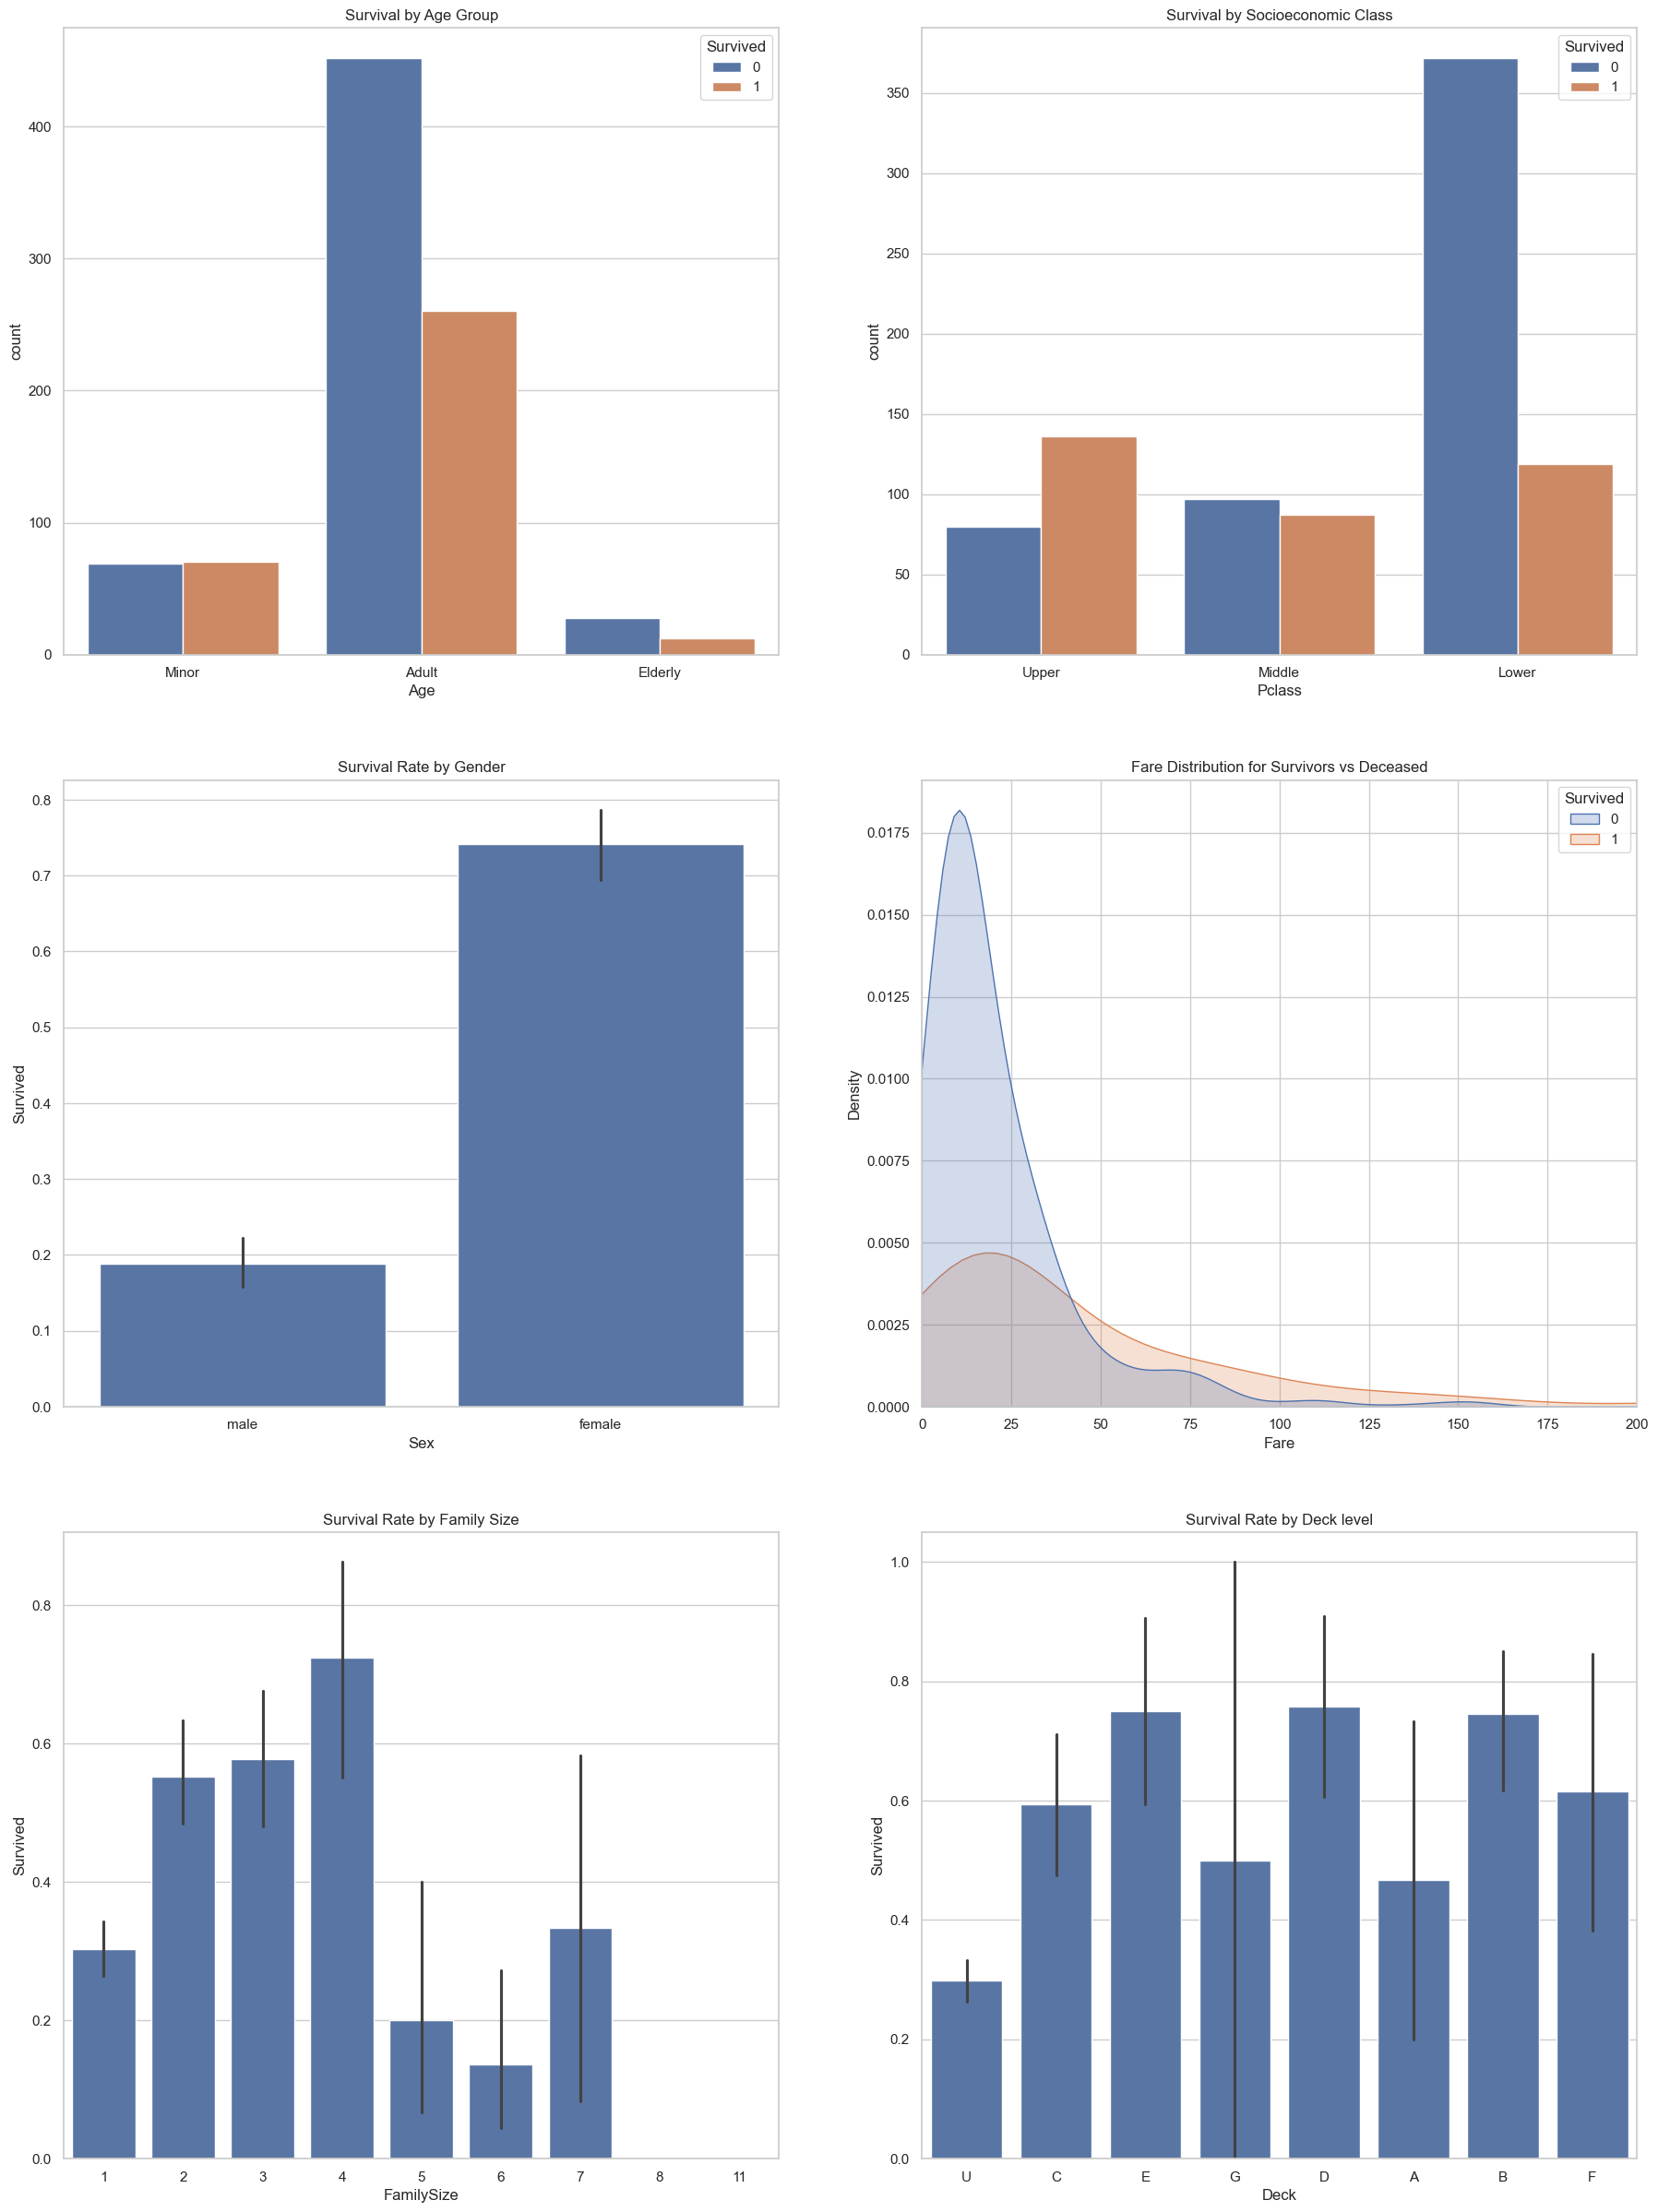

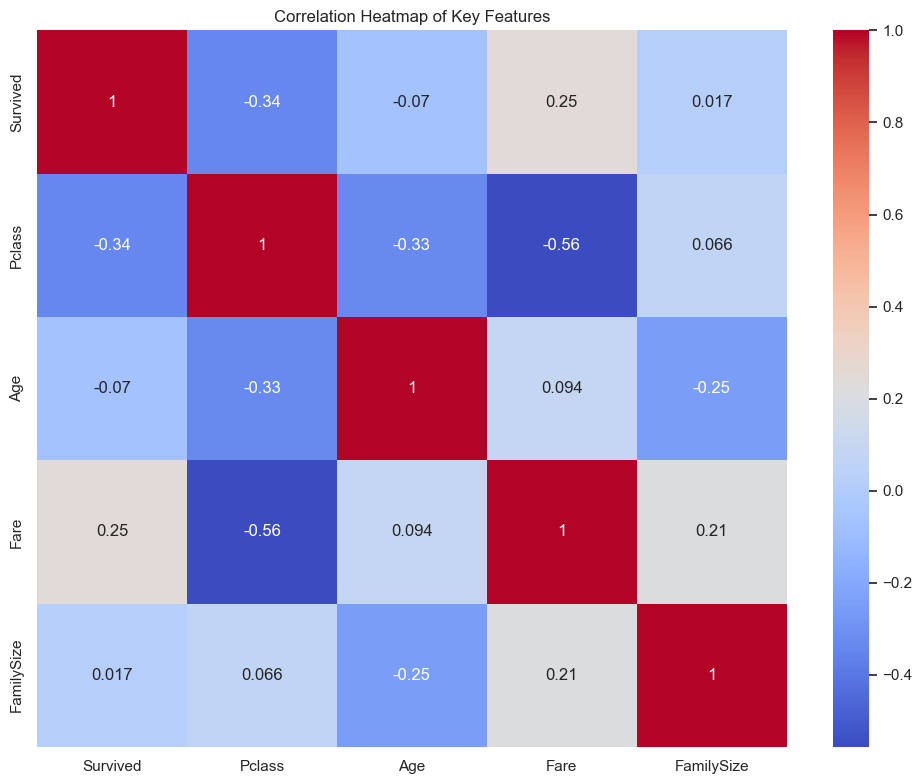

In [112]:
pclasses = pd.cut(pass_data['Pclass'], [0, 1, 2, 3], labels=['Upper', 'Middle', 'Lower']) 
ages = pd.cut(pass_data['Age'], [0, 18, 55, 80], labels=['Minor', 'Adult', 'Elderly']) 
pass_data['FamilySize'] = pass_data['SibSp'] + pass_data['Parch'] + 1 
pass_data['IsAlone'] = (pass_data['FamilySize'] == 1).astype(int)

sns.set_theme(style='whitegrid') 

fig, axes = plt.subplots(3, 2, figsize=(22, 30))

sns.countplot(x=ages, hue=pass_data['Survived'], ax=axes[0,0]) 
axes[0,0].set_title('Survival by Age Group')

sns.countplot(x=pclasses, hue=pass_data['Survived'], ax=axes[0,1]) 
axes[0,1].set_title('Survival by Socioeconomic Class')

sns.barplot(x='Sex', y='Survived', data=pass_data, ax=axes[1,0]) 
axes[1,0].set_title('Survival Rate by Gender')

sns.kdeplot(data=pass_data, x='Fare', hue='Survived', fill=True, ax=axes[1,1]) 
axes[1,1].set_xlim(0, 200) 
axes[1,1].set_title('Fare Distribution for Survivors vs Deceased')

sns.barplot(x='FamilySize', y='Survived', data=pass_data, ax=axes[2,0]) 
axes[2,0].set_title('Survival Rate by Family Size')

sns.barplot(x='Deck', y='Survived', data=pass_data, ax=axes[2, 1])
axes[2,1].set_title('Survival Rate by Deck level')

fig_2, axes_2 = plt.subplots(figsize=(10, 8))
sns.heatmap(pass_data[['Survived', 'Pclass', 'Age', 'Fare', 'FamilySize']].corr(), annot=True, cmap='coolwarm', ax=axes_2) 
axes_2.set_title('Correlation Heatmap of Key Features')

plt.tight_layout() 
plt.show()

Based on the plots, we won't be binning the age into categories since our model can wrongly imply that being an adult correlates with a higher chance of death.

We observe a few interesting characteristics from our plot:
- People of lower class status were more likely to not survive
- Females are more likely to survive
- Death is heavily biased toward those of lower socio-economic classes. If a passenger paid less than $25, then they would be more likely to not survive
- Those in family of four were more likely to survive, but the ones in a family of six are the least likely to survive
- Deck level looks noisy, this signals we should aggregate the deck into `ABC`, `DE`, `FG` and `U` to make it more uniform

Text(0.5, 1.0, 'Survival Rate by Deck level')

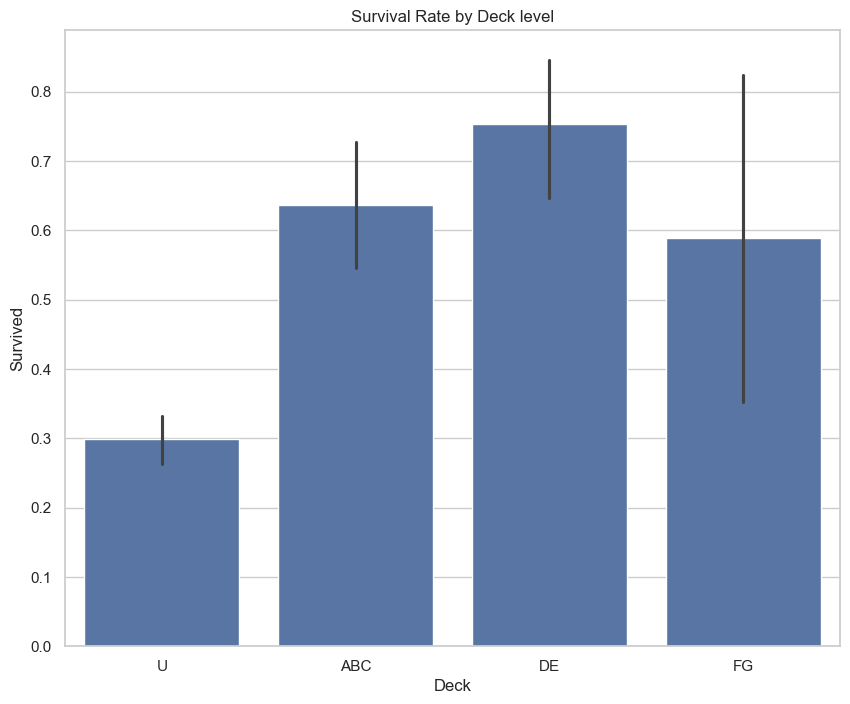

In [113]:
pass_data['Deck'] = pass_data['Deck'].replace(['A', 'T'], 'ABC')
pass_data['Deck'] = pass_data['Deck'].replace(['B', 'C'], 'ABC')
pass_data['Deck'] = pass_data['Deck'].replace(['D', 'E'], 'DE')
pass_data['Deck'] = pass_data['Deck'].replace(['F', 'G'], 'FG')

fig_3, axes_3 = plt.subplots(figsize=(10, 8))
sns.barplot(x='Deck', y='Survived', data=pass_data, ax=axes_3)
axes_3.set_title('Survival Rate by Deck level')

With the plots analyzed, we ought to get the dummies for some columns like `pClasses`, `Deck`